# Brain Tumor MRI Classification - Scikit-learn Baseline

## Introduction

Brain MRI scans provide structured information about tissue patterns. Differences in shape, contrast, and texture can indicate whether a tumour is present and, if so, what type. For a radiologist, these differences are interpreted visually. For us, the task is to translate them into numerical features that a computer can analyse.

The dataset we will use - [Brain Tumor MRI Dataset (CC0)](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset) - contains four categories: glioma, meningioma, pituitary tumour, and no tumour. Our aim is not to build a clinical tool but to create a clear, reproducible baseline using classical machine learning.

We will do this by:

* Loading the dataset either from local files or through the Kaggle API if credentials are available
* Preprocessing the MRI images (resize, grayscale, normalise) so they are consistent
* Extracting features using Histogram of Oriented Gradients (HOG), a method that captures edge and texture patterns
* Training simple classifiers such as Linear SVM and RBF SVM
* Evaluating the models with accuracy, precision, recall, and F1 score
* Discussing the limitations of this approach and the ethical considerations of using medical datasets

The goal is to show, step by step, how images can be prepared and processed for classical machine learning, and how model results should be interpreted with care. This gives us a strong foundation for understanding the workflow before moving into more advanced methods such as deep learning.

Perfect - here’s the updated **Setup - Libraries & Environment** section with `python -m pip` commands throughout (no bare `pip install`). I also kept the step-by-step walk-through for environment creation, installs, and Kaggle API setup.

## Setup - Libraries & Environment

Any meaningful exploration begins with the right tools. In neuroscience, this might mean calibrated electrodes or imaging equipment. In data analysis, our “lab bench” is the computational environment. Getting this right ensures that every step that follows is reliable and reproducible.

The core tools we’ll use are:

* **Python** - The language itself. Human-readable, flexible, and supported by a massive ecosystem of libraries.
* **NumPy** - The mathematical engine for fast, vectorised operations on arrays and matrices.
* **Pandas** - A high-level library for structuring and manipulating tabular data.
* **Matplotlib** - The foundational plotting library for turning numbers into visual insights.
* **scikit-learn** - Our main machine learning toolkit, providing SVMs, metrics, and utilities.
* **scikit-image** - Adds image-specific tools such as Histogram of Oriented Gradients (HOG).
* **kaggle** - A small command-line tool for downloading datasets directly from Kaggle.

### Creating your environment

It’s best to isolate your work in a virtual environment and install the required packages from `requirements.txt`. This ensures consistency and reduces version conflicts.

```bash
# Create a virtual environment
python -m venv venv
source venv/bin/activate    # macOS/Linux
venv\Scripts\activate       # Windows

# Install the required libraries
python -m pip install -r requirements.txt
```

That’s a great way to phrase it. Since you’ve **already provided the dataset in `data/raw/`**, we can make this section crystal clear: the data is ready to go, but users can re-download or update it themselves if they want. Here’s a tightened version you can drop straight into your notebook or README:

Perfect - here’s how you can present it in your notebook so users can run the update **directly in Python**, without leaving Jupyter. I’ll keep the explanation clear and practical.

### Accessing the dataset

The dataset is already included in this repository under `data/raw/`, so you can start working immediately.

If you prefer to download or update the dataset yourself, there are two options:

* **Manual download:**

  1. Visit the [Kaggle dataset page](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).
  2. Download the files manually.
  3. Place them in `data/raw/` inside your project folder.

* **Automatic download (requires API key):**

  1. In your Kaggle account settings, generate an API token. This downloads a file called `kaggle.json`.
  2. Place `kaggle.json` in `~/.kaggle/` (Linux/macOS) or `C:\Users\<YourName>\.kaggle\` (Windows).
  3. With the API configured, you can run the following Python cell inside the notebook to **force-update** the dataset into `data/raw/`:

In [ ]:
import os, shutil
from kaggle.api.kaggle_api_extended import KaggleApi

# Remove old dataset (optional clean overwrite)
shutil.rmtree("../data/raw", ignore_errors=True)
os.makedirs("../data/raw", exist_ok=True)  # Create fresh folder

# Authenticate with Kaggle (requires kaggle.json or env vars)
api = KaggleApi()
api.authenticate()

# Download and extract the Brain Tumor MRI dataset
api.dataset_download_files(
    "masoudnickparvar/brain-tumor-mri-dataset",
    path="../data/raw",
    unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


## Verify the Data

Before building models, we want to confirm that the dataset is structured correctly. The Brain Tumor MRI dataset is already split into **Training** and **Testing** folders, and each contains four subfolders: `glioma`, `meningioma`, `notumor`, and `pituitary`.

We will check:

1. That the expected folders exist.
2. How many images each class contains.
3. A few sample images for a quick sanity check.

### Check the folder structure

First, let’s confirm that both the training and testing folders contain the expected class subdirectories.

In [ ]:
training_path = "../data/raw/Training"
testing_path = "../data/raw/Testing"

print("Training classes:", os.listdir(training_path))
print("Testing classes:", os.listdir(testing_path))

Training classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Testing classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


### Count the number of images per class

Next, we will count how many images belong to each class in both splits. This helps us understand the balance of the dataset.

In [10]:
def count_images_per_class(split_path):
    counts = {}
    class_names = sorted(os.listdir(split_path))
    for class_name in class_names:
        class_folder = os.path.join(split_path, class_name)
        image_files = [
            f for f in os.listdir(class_folder)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ]
        counts[class_name] = len(image_files)
    return counts

training_counts = count_images_per_class(training_path)
testing_counts = count_images_per_class(testing_path)

print("Training image counts per class:", training_counts)
print("Testing image counts per class:", testing_counts)

Training image counts per class: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing image counts per class: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


### Visualise sample images

Finally, let’s display a handful of sample images from the training set. Normally this step helps confirm that the images are readable and match their labels – it doesn’t help me at all though, since I am not a neuroscientist.

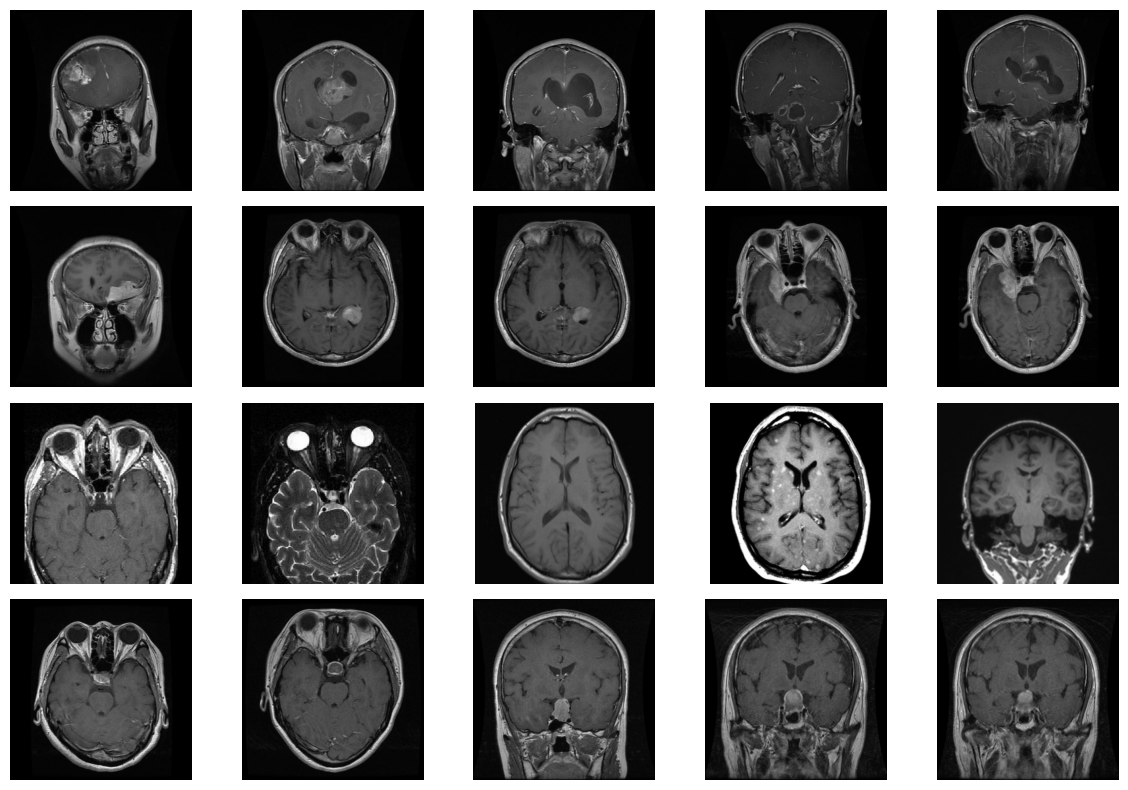

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(len(training_counts), 5, figsize=(12, 8))

for row, class_name in enumerate(training_counts.keys()):
    class_folder = os.path.join(training_path, class_name)
    image_files = [
        f for f in os.listdir(class_folder)
        if f.lower().endswith((".jpg", ".png", ".jpeg"))
    ]
    for col, image_file in enumerate(image_files[:5]):
        image = mpimg.imread(os.path.join(class_folder, image_file))
        axes[row, col].imshow(image, cmap="gray")
        axes[row, col].axis("off")
        if col == 0:
            axes[row, col].set_ylabel(class_name, fontsize=10, rotation=0, labelpad=30)

plt.tight_layout()
plt.show()

## Data Cleanup

Before extracting features, it is important to confirm that the dataset is usable. We need to check that:

1. All images can be opened without errors.
2. There are no duplicate images across or within the training and testing sets.
3. Any issues are logged, and problematic files are removed before proceeding.

### Verify image readability

We attempt to open every image. If any cannot be read, we record its path and remove it from the dataset.

In [ ]:
import csv

training_path = "../data/raw/Training"
testing_path = "../data/raw/Testing"
logs_directory = "../outputs/tables"
os.makedirs(logs_directory, exist_ok=True)

def verify_and_remove_images(split_path, log_file_path):
    unreadable_files = []
    for class_name in sorted(os.listdir(split_path)):
        class_folder = os.path.join(split_path, class_name)
        for file_name in os.listdir(class_folder):
            if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
                file_path = os.path.join(class_folder, file_name)
                try:
                    Image.open(file_path).verify()
                except Exception:
                    unreadable_files.append(file_path)

    # Log unreadable files
    with open(log_file_path, "w", newline="", encoding="utf-8") as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["file_path", "reason"])
        for file_path in unreadable_files:
            writer.writerow([file_path, "unreadable"])

    # Remove unreadable files
    removed_count = 0
    for file_path in unreadable_files:
        try:
            os.remove(file_path)
            removed_count += 1
        except FileNotFoundError:
            pass

    return unreadable_files, removed_count

unreadable_training_files, removed_training_count = verify_and_remove_images(
    training_path, os.path.join(logs_directory, "unreadable_training_files.csv")
)
unreadable_testing_files, removed_testing_count = verify_and_remove_images(
    testing_path, os.path.join(logs_directory, "unreadable_testing_files.csv")
)

print(f"Unreadable training images removed: {removed_training_count}")
print(f"Unreadable testing images removed: {removed_testing_count}")


Unreadable training images removed: 0
Unreadable testing images removed: 0


### Check for duplicates

We generate an MD5 hash per image. Files with the same hash are considered duplicates.
* If duplicates are found within the same category, we keep one copy and delete the rest.
* If duplicates are found across different categories in the same split, we cannot know which label is correct, so we delete all copies.
* All removals are logged to CSV.

In [ ]:
import hashlib

training_path = "../data/raw/Training"
testing_path  = "../data/raw/Testing"
logs_directory = "../outputs/tables"
os.makedirs(logs_directory, exist_ok=True)

def calculate_md5_hash(file_path):
    with open(file_path, "rb") as file_stream:
        return hashlib.md5(file_stream.read()).hexdigest()

def list_image_paths(root_path):
    image_paths = []
    for class_name in sorted(os.listdir(root_path)):
        class_folder = os.path.join(root_path, class_name)
        if not os.path.isdir(class_folder):
            continue
        for file_name in os.listdir(class_folder):
            if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(class_folder, file_name))
    return sorted(image_paths)

def remove_within_split_duplicates(split_path, log_csv_path):
    image_paths = list_image_paths(split_path)
    hash_to_paths = {}
    for image_path in image_paths:
        file_hash = calculate_md5_hash(image_path)
        hash_to_paths.setdefault(file_hash, []).append(image_path)

    files_to_remove = []
    kept_files = []

    for file_hash, paths_with_same_hash in hash_to_paths.items():
        if len(paths_with_same_hash) <= 1:
            continue

        # Group paths by category name
        categories = {os.path.basename(os.path.dirname(p)) for p in paths_with_same_hash}

        if len(categories) > 1:
            # Same file in different categories → all are invalid
            files_to_remove.extend(paths_with_same_hash)
        else:
            # Same file duplicated within one category → keep 1, remove rest
            sorted_paths = sorted(paths_with_same_hash)
            keep_path = sorted_paths[0]
            remove_paths = sorted_paths[1:]
            kept_files.append(keep_path)
            files_to_remove.extend(remove_paths)

    # Log and remove
    with open(log_csv_path, "w", newline="", encoding="utf-8") as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(["file_path", "reason"])
        for file_path in sorted(set(files_to_remove)):
            csv_writer.writerow([
                file_path,
                "duplicate_across_categories" if file_path in files_to_remove and len({os.path.basename(os.path.dirname(p)) for p in hash_to_paths[calculate_md5_hash(file_path)]}) > 1
                else "duplicate_within_category"
            ])

    removed_count = 0
    for file_path in sorted(set(files_to_remove)):
        try:
            os.remove(file_path)
            removed_count += 1
        except FileNotFoundError:
            pass

    return removed_count

# Remove duplicates in Training
training_duplicates_log = os.path.join(logs_directory, "duplicate_files_removed_training.csv")
removed_training_duplicates = remove_within_split_duplicates(training_path, training_duplicates_log)

# Remove duplicates in Testing
testing_duplicates_log = os.path.join(logs_directory, "duplicate_files_removed_testing.csv")
removed_testing_duplicates = remove_within_split_duplicates(testing_path, testing_duplicates_log)

print(f"Training duplicates removed: {removed_training_duplicates} (logged to {training_duplicates_log})")
print(f"Testing duplicates removed: {removed_testing_duplicates} (logged to {testing_duplicates_log})")

Training duplicates removed: 191 (logged to ../outputs/tables\duplicate_files_removed_training.csv)
Testing duplicates removed: 27 (logged to ../outputs/tables\duplicate_files_removed_testing.csv)


### Re-count after clean up

Finally, we re-count how many images remain per class in both training and testing sets.

In [17]:
def count_images_per_class(split_path):
    counts = {}
    class_names = sorted([d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))])
    for class_name in class_names:
        class_folder = os.path.join(split_path, class_name)
        image_files = [
            file_name for file_name in os.listdir(class_folder)
            if file_name.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        counts[class_name] = len(image_files)
    return counts

training_counts_clean = count_images_per_class(training_path)
testing_counts_clean = count_images_per_class(testing_path)

print("Training image counts per class:", training_counts_clean)
print("Testing image counts per class:", testing_counts_clean)

Training image counts per class: {'glioma': 1321, 'meningioma': 1333, 'notumor': 1422, 'pituitary': 1445}
Testing image counts per class: {'glioma': 299, 'meningioma': 304, 'notumor': 381, 'pituitary': 300}


## 5. Reproducibility Controls - Ensuring Consistency

Before we preprocess or extract features, we lock down the environment. This makes results comparable and easier to debug. We will:

* Set global random seeds so splits and training are stable.
* Fix image size and HOG parameters in one place.
* Record library versions and all key parameters to a JSON file.
* Keep this metadata under `outputs/run_meta.json` for future runs.

In [ ]:
import sys
import json
import random
import platform

import numpy as np
import matplotlib
import pandas as pd
import sklearn
import skimage

# Create outputs directory
outputs_directory = "../outputs"
os.makedirs(outputs_directory, exist_ok=True)

# Global seeds
random_seed = 42
os.environ["PYTHONHASHSEED"] = str(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

# Image settings
image_height = 128
image_width = 128
image_channels = 1

# HOG parameters
hog_parameters = {
    "orientations": 9,
    "pixels_per_cell": (8, 8),
    "cells_per_block": (2, 2),
    "block_norm": "L2-Hys",
    "transform_sqrt": True
}

# Split settings
validation_fraction = 0.15
shuffle_before_split = True

# Paths
training_path = "../data/raw/Training"
testing_path = "../data/raw/Testing"

# Package versions and environment info
environment_info = {
    "python_version": sys.version.split()[0],
    "platform": platform.platform(),
    "numpy_version": np.__version__,
    "pandas_version": pd.__version__,
    "matplotlib_version": matplotlib.__version__,
    "scikit_learn_version": sklearn.__version__,
    "scikit_image_version": skimage.__version__
}

# Collect run metadata
run_metadata = {
    "random_seed": random_seed,
    "image_settings": {
        "height": image_height,
        "width": image_width,
        "channels": image_channels
    },
    "hog_parameters": hog_parameters,
    "split_settings": {
        "validation_fraction": validation_fraction,
        "shuffle_before_split": shuffle_before_split
    },
    "paths": {
        "training_path": training_path,
        "testing_path": testing_path,
        "outputs_directory": outputs_directory
    },
    "environment": environment_info
}

# Save metadata
run_meta_path = os.path.join(outputs_directory, "run_meta.json")
with open(run_meta_path, "w", encoding="utf-8") as json_file:
    json.dump(run_metadata, json_file, indent=2)

print(f"Reproducibility metadata saved to: {run_meta_path}")
print("Seed initialised and parameters fixed.")

Reproducibility metadata saved to: ../outputs\run_meta.json
Seed initialised and parameters fixed.


## Preprocessing Pipeline - From images to consistent arrays

Goal: standardise every image so the model sees the same input shape and scale.

We will:

* Read each file safely.
* Convert to grayscale.
* Resize to the fixed shape we set earlier.
* Scale pixel values to `[0, 1]`.
* Build `X` (features) and `y` (labels) from the Training split.
* Save a small preview to confirm it worked.

### Helpers - load, standardise, and collect data



In [20]:
from typing import Tuple, List, Dict

from skimage import io, color, transform, util

# image_height, image_width, training_path
class_label_to_index: Dict[str, int] = {}

def load_image_as_grayscale_resized(image_path: str,
                                    target_height: int,
                                    target_width: int) -> np.ndarray:
    """Read image, convert to grayscale (handles 1/3/4 channels), resize, scale to [0,1]."""
    try:
        image = io.imread(image_path)
    except Exception:
        # Fallback to PIL if skimage fails
        image = np.array(Image.open(image_path).convert("RGB"))

    if image.ndim == 3:
        channels = image.shape[2]
        if channels == 4:
            # RGBA -> RGB -> grayscale
            image = color.rgba2rgb(image)
            image = color.rgb2gray(image)
        elif channels == 3:
            # RGB -> grayscale
            image = color.rgb2gray(image)
        else:
            # Unexpected channels: force PIL grayscale
            image = np.array(Image.open(image_path).convert("L")) / 255.0
    elif image.ndim == 2:
        # Already grayscale; ensure float in [0,1]
        image = image.astype(np.float32)
        if image.max() > 1.0:
            image = image / 255.0
    else:
        image = np.array(Image.open(image_path).convert("L")) / 255.0

    image = util.img_as_float32(image)
    image_resized = transform.resize(
        image, (target_height, target_width),
        anti_aliasing=True, preserve_range=True
    ).astype(np.float32)

    return image_resized

def list_class_folders(root_path: str) -> List[str]:
    """Return sorted class folder names for reproducible label mapping."""
    return sorted([d for d in os.listdir(root_path)
                   if os.path.isdir(os.path.join(root_path, d))])

def build_dataset_arrays(root_path: str,
                         target_height: int,
                         target_width: int) -> Tuple[np.ndarray, np.ndarray, Dict[str, int]]:
    """Create X, y from folder structure: root/class_name/*.jpg|png."""
    class_names = list_class_folders(root_path)

    # Deterministic mapping
    label_to_index = {name: idx for idx, name in enumerate(class_names)}

    features_list: List[np.ndarray] = []
    labels_list: List[int] = []

    for class_name in class_names:
        class_folder = os.path.join(root_path, class_name)
        image_files = [file_name for file_name in os.listdir(class_folder)
                       if file_name.lower().endswith((".jpg", ".jpeg", ".png"))]
        for file_name in image_files:
            image_path = os.path.join(class_folder, file_name)
            try:
                image_resized = load_image_as_grayscale_resized(
                    image_path, target_height, target_width
                )
                features_list.append(image_resized)
                labels_list.append(label_to_index[class_name])
            except Exception as error:
                print(f"Skipping {image_path}: {error}")

    features_array = np.stack(features_list, axis=0)
    labels_array = np.array(labels_list, dtype=np.int64)

    return features_array, labels_array, label_to_index

# Build arrays for Training split
X_train_images, y_train, class_label_to_index = build_dataset_arrays(
    training_path, image_height, image_width
)

print("Training features shape (N, H, W):", X_train_images.shape)
print("Training labels shape (N,):", y_train.shape)
print("Class mapping:", class_label_to_index)


Training features shape (N, H, W): (5521, 128, 128)
Training labels shape (N,): (5521,)
Class mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


### Visual Check - preprocessed samples

Show a small grid of preprocessed images to confirm two basics: the images are grayscale and the size is consistent.

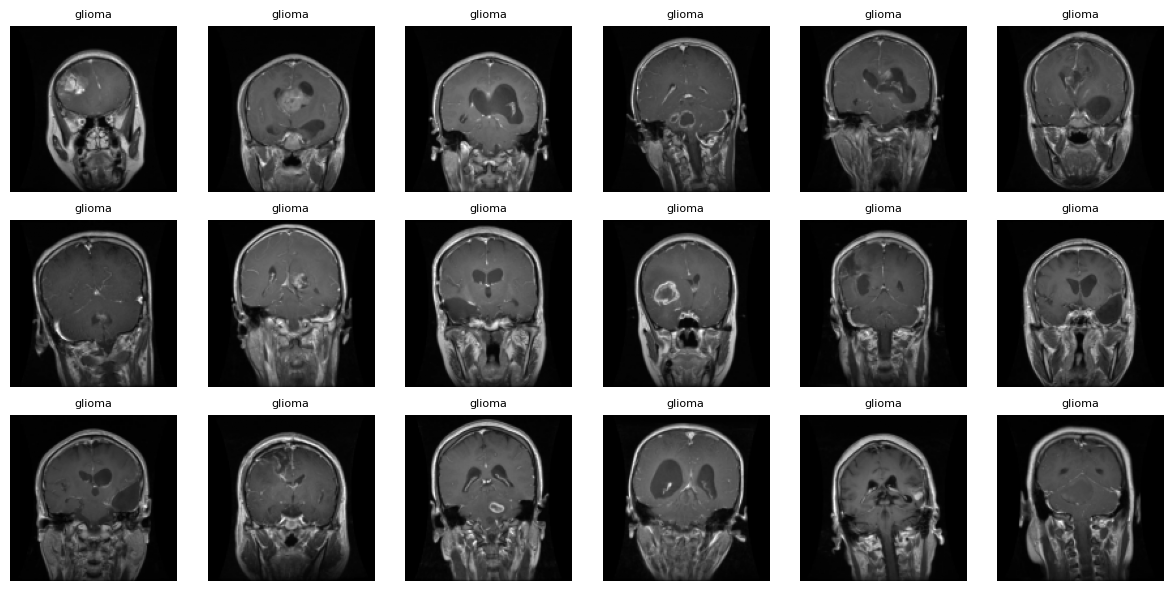

In [21]:
def plot_preprocessed_grid(images: np.ndarray,
                           labels: np.ndarray,
                           index_to_label: Dict[int, str],
                           rows: int = 3,
                           cols: int = 6) -> None:
    """Plot a grid of preprocessed images."""
    total = min(rows * cols, images.shape[0])
    plt.figure(figsize=(12, 6))
    for idx in range(total):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(images[idx], cmap="gray")
        plt.axis("off")
        plt.title(index_to_label[int(labels[idx])], fontsize=8)
    plt.tight_layout()
    plt.show()

index_to_label = {v: k for k, v in class_label_to_index.items()}
plot_preprocessed_grid(X_train_images, y_train, index_to_label)